# Renyi pix2pix: Image-to-image translation

In [1]:
import tensorflow as tf

import os
import pathlib
import time
import datetime

from matplotlib import pyplot as plt
from IPython import display

from utils import *
from pix2pix_model import *
from losses import *

## Load dataset

In [2]:
dataset_name = "facades" #@param ["cityscapes", "edges2handbags", "edges2shoes", "facades", "maps", "night2day"]


In [3]:
_URL = f'http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/{dataset_name}.tar.gz'

path_to_zip = tf.keras.utils.get_file(
    fname=f"{dataset_name}.tar.gz",
    origin=_URL,
    extract=True)

path_to_zip  = pathlib.Path(path_to_zip)

PATH = path_to_zip.parent/dataset_name

30179328/30168306 [==============================] - 7s 0us/step


In [4]:
list(PATH.parent.iterdir())

[PosixPath('/root/.keras/datasets/facades.tar.gz'),
 PosixPath('/root/.keras/datasets/facades')]

Each original image is of size `256 x 512` containing two `256 x 256` images:

In [5]:
sample_image = tf.io.read_file(str(PATH / 'train/1.jpg'))
sample_image = tf.io.decode_jpeg(sample_image)
print(sample_image.shape)

2022-03-19 15:33:06.323980: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-19 15:33:06.414147: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-19 15:33:06.414914: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-19 15:33:06.419075: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

(256, 512, 3)


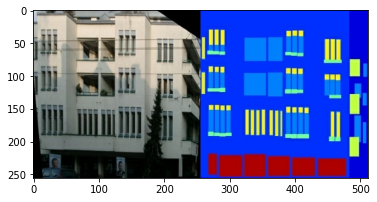

In [6]:
plt.figure()
plt.imshow(sample_image)

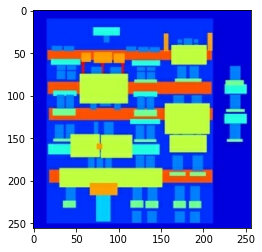

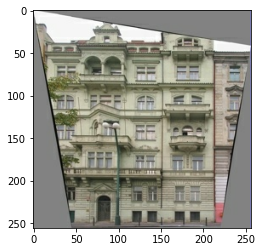

In [7]:
inp, re = load(str(PATH / 'train/100.jpg'))
# Casting to int for matplotlib to display the images
plt.figure()
plt.imshow(inp / 255.0)
plt.figure()
plt.imshow(re / 255.0)

apply random jittering and mirroring to preprocess the training set (as per pix2pix paper).

In [8]:
# The facade training set consist of 400 images
BUFFER_SIZE = 400
# The batch size of 1 produced better results for the U-Net in the original pix2pix experiment
BATCH_SIZE = 1
# Each image is 256x256 in size
IMG_WIDTH = 256
IMG_HEIGHT = 256

2022-03-19 15:33:10.620016: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


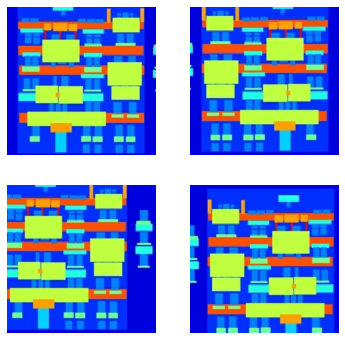

In [9]:
plt.figure(figsize=(6, 6))
for i in range(4):
  rj_inp, rj_re = random_jitter(inp, re)
  plt.subplot(2, 2, i + 1)
  plt.imshow(rj_inp / 255.0)
  plt.axis('off')
plt.show()

## Build input pipeline with `tf.data`

In [10]:
train_dataset = tf.data.Dataset.list_files(str(PATH / 'train/*.jpg'))
train_dataset = train_dataset.map(load_image_train,
                                  num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

In [11]:
try:
  test_dataset = tf.data.Dataset.list_files(str(PATH / 'test/*.jpg'))
except tf.errors.InvalidArgumentError:
  test_dataset = tf.data.Dataset.list_files(str(PATH / 'val/*.jpg'))
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(BATCH_SIZE)

## Define Generator (Modified U-Net)

Visualize the generator model architecture:

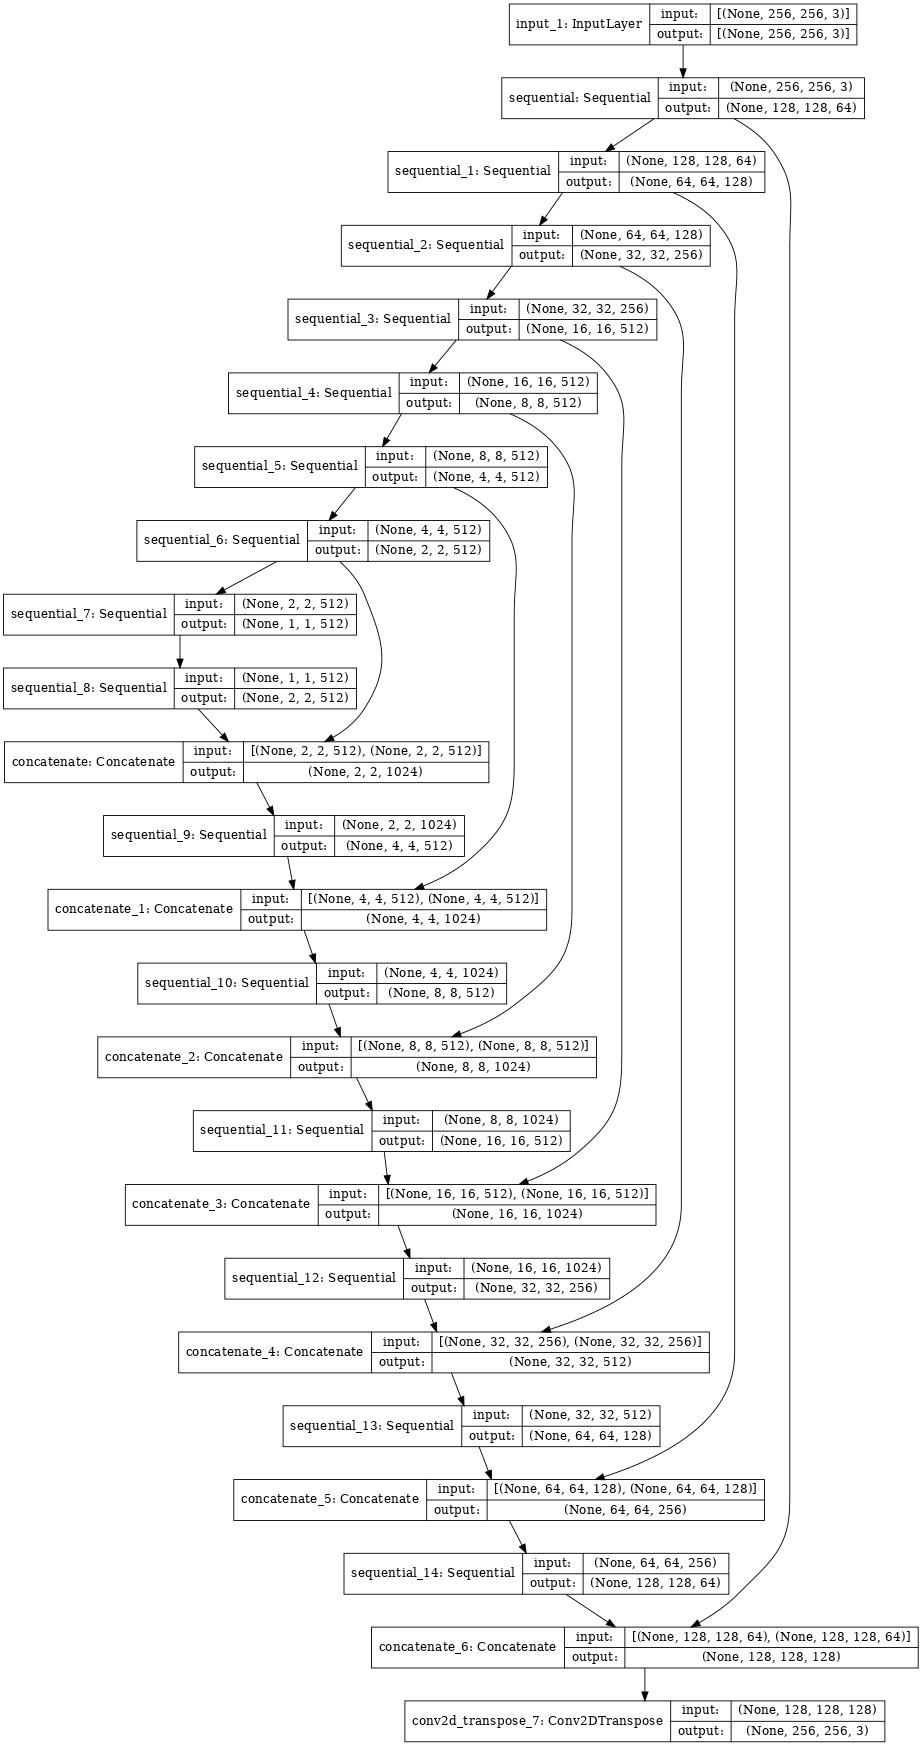

In [12]:
generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

Test the generator:

2022-03-19 15:33:14.737907: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


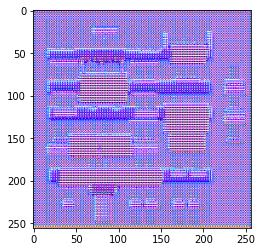

In [13]:
gen_output = generator(inp[tf.newaxis, ...], training=False)
plt.imshow(gen_output[0, ...])

## Define discriminator (Convolutional PatchGAN)

Visualize the discriminator model architecture:

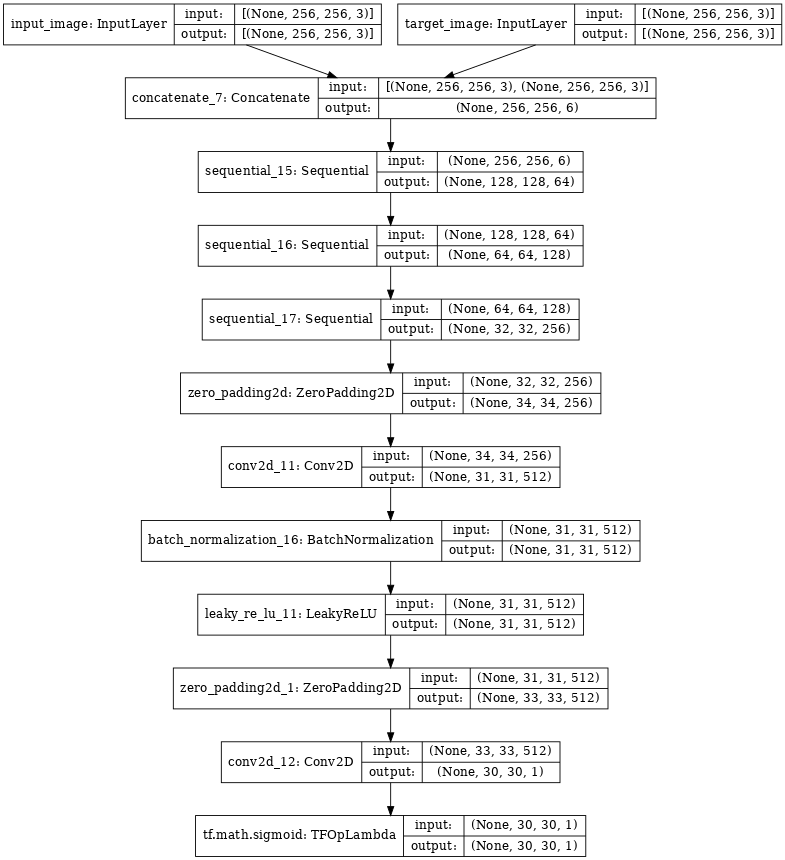

In [14]:
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

Test the discriminator:

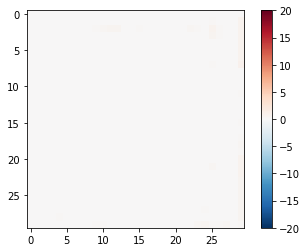

In [15]:
disc_out = discriminator([inp[tf.newaxis, ...], gen_output], training=False)
plt.imshow(disc_out[0, ..., -1], vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar()

## Define Loss Functions for Generator and Discriminator

Currently generator loss is renyi-crossentropy + L1 Regularization and discriminator loss is standard cross-entropy

In [16]:
alpha = 3
lamda = 100 # NOTE: I found (empirically) that regularization is crucial (w no regularization, the generator gets stuck)

generator_loss = create_gen_loss(alpha, lamda=lamda)
discriminator_loss = discriminator_loss

## Define optimizers and checkpoint-saver


In [17]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [18]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Generate images (test before training)

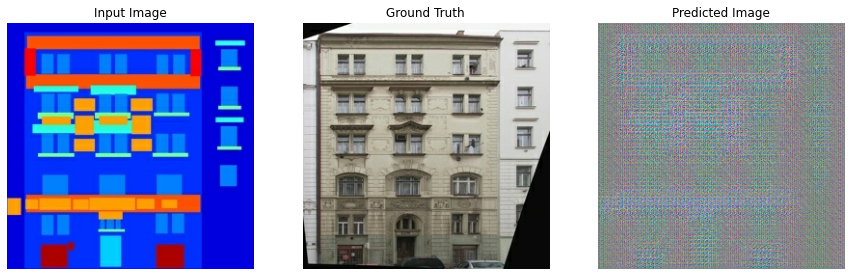

In [19]:
for example_input, example_target in test_dataset.take(1):
  generate_images(generator, example_input, example_target)

## Training

In [20]:
log_dir="logs/"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [21]:
@tf.function
def train_step(input_image, target, step):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)

    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)

    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

  with summary_writer.as_default():
    tf.summary.scalar('gen_total_loss', gen_total_loss, step=step//1000)
    tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=step//1000)
    tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=step//1000)
    tf.summary.scalar('disc_loss', disc_loss, step=step//1000)

  return gen_total_loss, disc_loss

In [22]:
def fit(train_ds, test_ds, steps):
  example_input, example_target = next(iter(test_ds.take(1)))
  start = time.time()

  for step, (input_image, target) in train_ds.repeat().take(steps).enumerate():
    if (step) % 1000 == 0:
      display.clear_output(wait=True)

      if step != 0:
        print(f'Time taken for 1000 steps: {time.time()-start:.2f} sec\n')
        print(f'gen_loss: {gen_loss}; disc_loss: {disc_loss}')

      start = time.time()

      generate_images(generator, example_input, example_target)
      print(f"Step: {step//1000}k")

    gen_loss, disc_loss = train_step(input_image, target, step)

    # Training step
    if (step+1) % 10 == 0:
      print('.', end='', flush=True)


    # Save (checkpoint) the model every 5k steps
    if (step + 1) % 5000 == 0:
      checkpoint.save(file_prefix=checkpoint_prefix)

In [23]:
%load_ext tensorboard
%tensorboard --logdir {log_dir}

Finally, run the training loop:

Time taken for 1000 steps: 54.80 sec

gen_loss: 15.181564331054688; disc_loss: 1.006408929824829


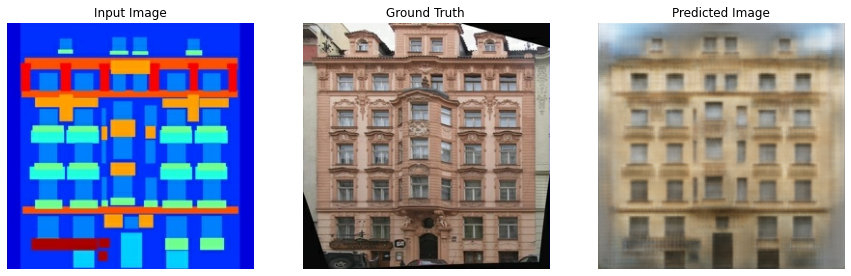

Step: 79k
....................................................................................................

In [24]:
fit(train_dataset, test_dataset, steps=80000)

In [25]:
display.IFrame(
    src="https://tensorboard.dev/experiment/lZ0C6FONROaUMfjYkVyJqw",
    width="100%",
    height="1000px")

## Restore latest checkpoint and test the network

In [26]:
!ls {checkpoint_dir}

checkpoint		     ckpt-2.data-00000-of-00001
ckpt-1.data-00000-of-00001   ckpt-2.index
ckpt-1.index		     ckpt-3.data-00000-of-00001
ckpt-10.data-00000-of-00001  ckpt-3.index
ckpt-10.index		     ckpt-4.data-00000-of-00001
ckpt-11.data-00000-of-00001  ckpt-4.index
ckpt-11.index		     ckpt-5.data-00000-of-00001
ckpt-12.data-00000-of-00001  ckpt-5.index
ckpt-12.index		     ckpt-6.data-00000-of-00001
ckpt-13.data-00000-of-00001  ckpt-6.index
ckpt-13.index		     ckpt-7.data-00000-of-00001
ckpt-14.data-00000-of-00001  ckpt-7.index
ckpt-14.index		     ckpt-8.data-00000-of-00001
ckpt-15.data-00000-of-00001  ckpt-8.index
ckpt-15.index		     ckpt-9.data-00000-of-00001
ckpt-16.data-00000-of-00001  ckpt-9.index
ckpt-16.index


In [27]:
# Restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## Generate images using the test set

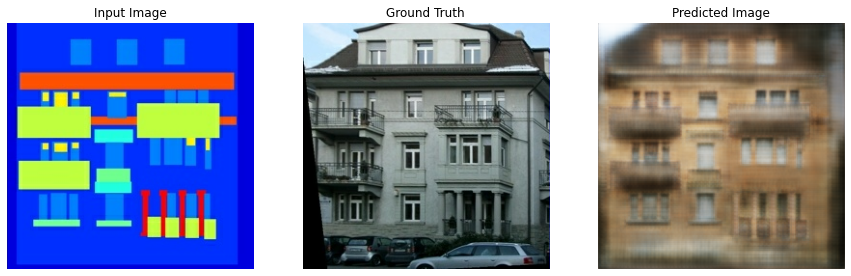

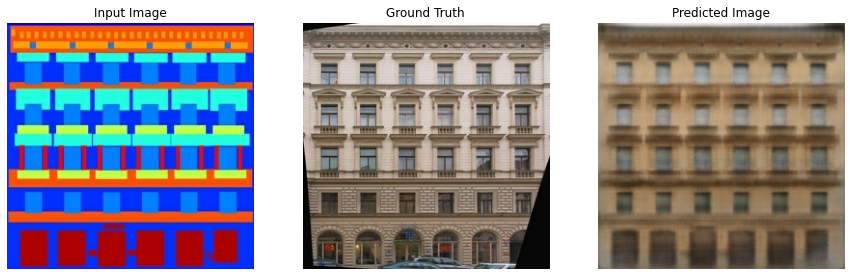

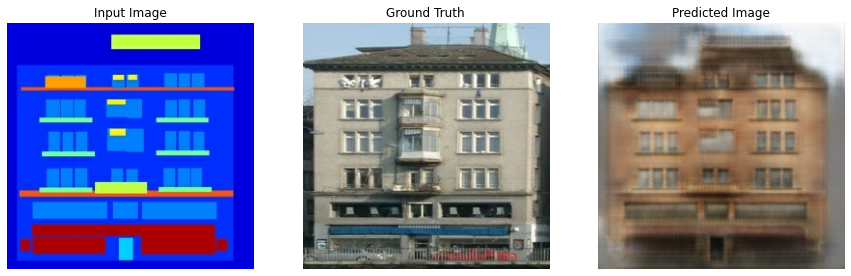

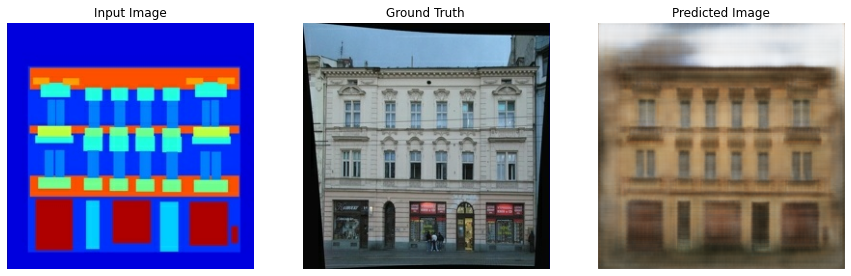

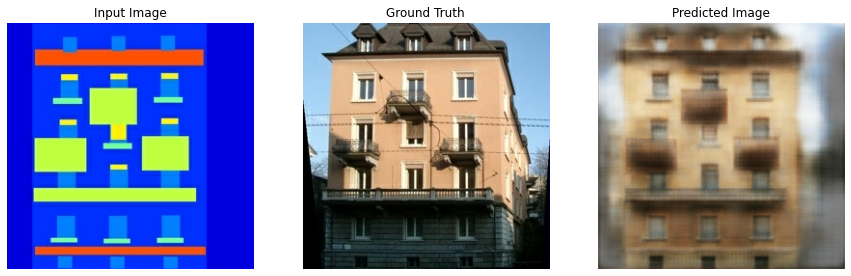

In [28]:
# Run the trained model on a few examples from the test set
for inp, tar in test_dataset.take(5):
  generate_images(generator, inp, tar)